In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import operator

import re
import nltk
from nltk import tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

stopwords = nltk.corpus.stopwords.words('english') + [chr(i) for i in range(ord('a'), ord('z') + 1)]

In [2]:
LEMMATIZER = WordNetLemmatizer()

def get_cleaned_text(text):
    """basic cleaning
        - lower case
        - keep alpha only
        - remove stop words
        - lemmatize?
    """
    text = text.lower()
    text = re.sub("[^a-z]", " ", text)
    text = ' '.join([word for word in text.split() if word not in stopwords])
    text = ' '.join([LEMMATIZER.lemmatize(token) for token in tokenize.word_tokenize(text)])
    
    return text

In [3]:
df = pd.read_csv("../input/nips-papers/papers.csv") # .sample(100).reset_index(drop=True)

df.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [4]:
# clean text col
df['paper_text'] = df['paper_text'].apply(get_cleaned_text)

# calc word and char count
df['word_count'] = df['paper_text'].apply(lambda x: len(x.split()))
df['char_count'] = df['paper_text'].apply(len)

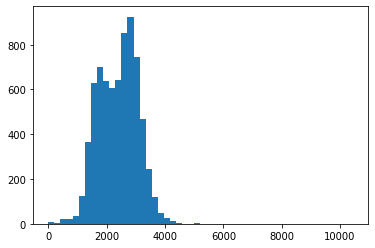

In [5]:
plt.hist(df['word_count'].values, bins=50);

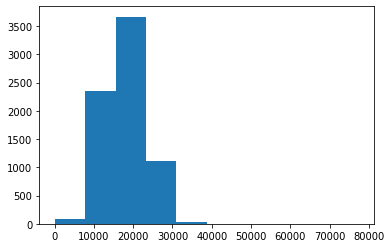

In [6]:
plt.hist(df['char_count'].values, bins=10);

In [7]:
# find top words (based on count)
word_count = {}

for text in df['paper_text'].tolist():
    for word in text.split():
        word = word.lower()
        word_count[word] = word_count.get(word, 0) + 1

word_count = {k: v for k, v in sorted(word_count.items(), key = lambda x: x[1], reverse=True)}

<AxesSubplot:>

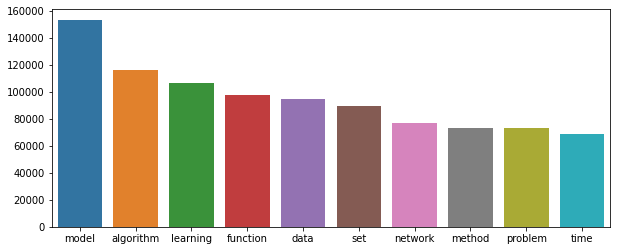

In [8]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x = list(word_count.keys())[:10], y = list(word_count.values())[:10])

### NMF for Topic Modelling

In [9]:
def get_nmf_topics(model, vectorizer, n_top_words):
    """NMF - topic names
        - given the model and vectorizer, return top n topic names
    """
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {}
    
    for i in range(num_topics):
        words_ids = model.components_[i].argsort()[:-20-1: -1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words
    
    return pd.DataFrame(word_dict)

In [10]:
def rank_terms(A, terms):
    """ranking of topics/terms
        - ranking the terms based on the the vectors
        - sum over each col
        - map weights to the terms
        - rank by weights
    """
    sums = A.sum(axis=0)
    weights = {}
    for col, term in enumerate(terms):
        weights[term] = sums[0,col]

    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

In [11]:
def get_descriptor(terms, H, topic_index, top):
    """
        - for a topic index (index for H), return top terms
    """
    # reverse sort the values to sort the indices
    top_indices = np.argsort(H[topic_index,:] )[::-1]
    
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append(terms[term_index])
        
    return top_terms

In [12]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append(w2v_model.wv.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

In [13]:
def get_top_snippets( all_snippets, W, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    # now get the snippets corresponding to the top-ranked indices
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets

In [14]:
text = df['paper_text'].tolist()

In [15]:
# count vec + tfidf transform
vectorizer = CountVectorizer(
    analyzer='word', 
    max_features=5000, 
    stop_words='english', 
    lowercase=True, 
    token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'
)

x_counts = vectorizer.fit_transform(text)

transformer = TfidfTransformer(smooth_idf=False)
x_tfidf = transformer.fit_transform(x_counts)

In [16]:
# normalizing before nmf
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

model = NMF(n_components=10, init='nndsvd');
model.fit(xtfidf_norm)

NMF(init='nndsvd', n_components=10)

In [17]:
# get top 10 topics for each sample

num_topics = 10
nmf_df = get_nmf_topics(model, vectorizer, num_topics)
nmf_df.head()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,model,neuron,score,mab,policy,image,hot,network,algorithm,acl
1,distribution,spike,ranking,arm,action,object,log,layer,kernel,act
2,data,cell,annotator,bandit,reward,feature,bound,unit,bound,amp
3,posterior,stimulus,feature,regret,agent,pixel,regret,input,matrix,kxt
4,inference,synaptic,sentence,ucb,state,model,arm,training,function,den


In [18]:
# raw_doc = [i.strip().lower().split() for i in text]

In [19]:
vectorizer = TfidfVectorizer(stop_words=stopwords, min_df = 20)

A = vectorizer.fit_transform(text)
terms = vectorizer.get_feature_names_out()

In [20]:
# ranking terms based on vectorized outpout
ranking = rank_terms(A, terms)

for i, pair in enumerate(ranking[0: 10]):
    print("%02d - %s (%.2f)" % (i+1, pair[0], pair[1]))

01 - model (389.07)
02 - algorithm (307.76)
03 - learning (278.09)
04 - network (275.23)
05 - data (256.66)
06 - function (251.73)
07 - set (218.86)
08 - image (207.37)
09 - method (195.40)
10 - problem (191.46)


In [21]:
k = 10
model = NMF(init="nndsvd", n_components=k ) 

W = model.fit_transform(A)
H = model.components_

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


In [22]:
descriptors = []
for topic_index in range(k):
    descriptors.append(get_descriptor(terms, H, topic_index, 10))
    str_descriptor = ", ".join( descriptors[topic_index])
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor))

Topic 01: regret, bound, algorithm, loss, xt, bandit, learning, function, theorem, online
Topic 02: network, layer, unit, input, training, weight, neural, output, hidden, learning
Topic 03: policy, action, reward, state, agent, reinforcement, learning, mdp, value, trajectory
Topic 04: image, object, feature, model, pixel, visual, patch, scene, face, segmentation
Topic 05: model, distribution, data, posterior, gaussian, likelihood, bayesian, variational, prior, inference
Topic 06: neuron, spike, stimulus, cell, synaptic, response, firing, activity, circuit, time
Topic 07: graph, node, tree, cluster, clustering, edge, algorithm, vertex, set, partition
Topic 08: kernel, svm, feature, xi, data, classifier, classification, learning, training, function
Topic 09: matrix, rank, algorithm, norm, sparse, problem, method, convex, tensor, optimization
Topic 10: topic, word, document, model, lda, latent, dirichlet, language, label, corpus


In [23]:
kmin, kmax = 2, 15
from sklearn import decomposition
topic_models = []

# try each value of k
for k in range(kmin, kmax + 1):
    
    print("Applying NMF for k=%d ..." % k )
    model = decomposition.NMF( init="nndsvd", n_components=k ) 
    
    W = model.fit_transform( A )
    H = model.components_
    
    # store for later
    topic_models.append((k,W,H))

Applying NMF for k=2 ...
Applying NMF for k=3 ...
Applying NMF for k=4 ...
Applying NMF for k=5 ...
Applying NMF for k=6 ...
Applying NMF for k=7 ...
Applying NMF for k=8 ...
Applying NMF for k=9 ...


/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Applying NMF for k=10 ...


/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Applying NMF for k=11 ...
Applying NMF for k=12 ...
Applying NMF for k=13 ...
Applying NMF for k=14 ...


/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Applying NMF for k=15 ...


In [24]:
class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall(doc):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens
            
import gensim
docgen = TokenGenerator(text, stopwords)
w2v_model = gensim.models.Word2Vec(docgen, vector_size=500, min_count=20, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [25]:
from itertools import combinations
k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 10))
        
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence = %.4f" % (k, coherences[-1]))

K=02: Coherence = 0.2691
K=03: Coherence = 0.2720
K=04: Coherence = 0.2707
K=05: Coherence = 0.2837
K=06: Coherence = 0.2773
K=07: Coherence = 0.2698
K=08: Coherence = 0.2794
K=09: Coherence = 0.2733
K=10: Coherence = 0.2759
K=11: Coherence = 0.2724
K=12: Coherence = 0.2716
K=13: Coherence = 0.2670
K=14: Coherence = 0.2702
K=15: Coherence = 0.2745


In [26]:
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
k = best_k

# get the model that we generated earlier.
W = topic_models[k - kmin][1]
H = topic_models[k - kmin][2]

In [27]:
for topic_index in range(k):
    descriptor = get_descriptor(terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % (topic_index + 1, str_descriptor))

Topic 01: algorithm, kernel, matrix, function, bound, problem, learning, theorem, method, xi
Topic 02: neuron, spike, cell, network, stimulus, synaptic, input, response, firing, activity
Topic 03: policy, action, reward, state, agent, learning, regret, reinforcement, algorithm, mdp
Topic 04: image, network, layer, object, training, feature, learning, model, unit, recognition
Topic 05: model, distribution, data, posterior, inference, latent, likelihood, variational, prior, bayesian
